## Neuron Simulator

I_AMPA(10, -64.2, [1.9, 22, 40]) =  -0.4237 mA
I_GABA(10, -64.2, array([3, 6])) =   0.2968 mA
V_t at the start is -63.00 mV
V_t after 100.0 ms is -52.75 mV
The value of [Cl-] that elicits a negative driving force of -0.17561269038506566 is >= 10


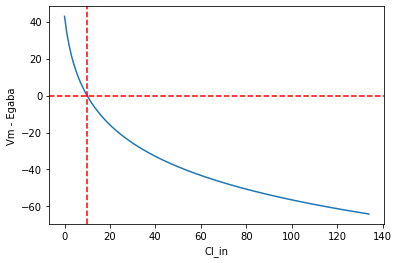

In [5]:
%run "synapse.ipynb"

In [14]:
import math
import logging

In [7]:
DEFAULT_V_REST = -65
DEFAULT_C_M = 1
DEFAULT_R_M = 100

class MyFirstNeuron:
    """ A point neuron that can receive spike times for GABAA and AMPA synapses, 
    as well as constant external current. Note this only models subthreshold 
    membrane potentials (no action potentials are generated).

    Note: although a point neuron, the length and radius of the neuron must be
    provided (in um).
    """
    def __init__(self, length, radius, name="my first neuron", R_m=DEFAULT_R_M, C_m=DEFAULT_C_M, V_0=DEFAULT_V_REST):
        
        print(f"creating neuron {name}")
    
        self.name = name
        self.length = length * 1e-5    # convert um to dm
        self.r = radius*1e-5
        self.R_m = R_m
        self.C_m = C_m
        self.V_rest = V_0
        self.I_e = 0
        
        # surface area of electrode placement (cm2)
        self.A = (np.pi * self.length * self.r) * 100
        # volume of sphere (dm3)     
        self.volume = 4/3 * np.pi * (self.length/2) * self.r**2
        # surface area of open cylinder (cm2)
        self.SA = (self.length*np.pi*self.r + 2*np.pi*self.r**2)*100 
        
        self.V_t = []               # record voltage
        self.inh_spks = []            # list for spikes that arrive at GABA synapses
        self.exc_spks = []            # list for spikes that arrive at AMPA synapses        
        
        # initialise variable for a simulation
        self.reinit()

    def set_inh_input(self, inh_spks):
        self.inh_spks = inh_spks

    def set_exc_input(self, exc_spks):
        self.exc_spks = exc_spks

    def set_external_input(self, I_e):
        # current is in μA
        self.I_e = I_e

    def _I_syn(self, t, V_t):
        """ Returns the sum of all synaptic currents.
        Note that the method starts with an underscore "_" to indicate that
        it should be for internal (to the class) use only!
        """
        return I_GABA(t, V_t, self.inh_spks) + I_AMPA(t, V_t, self.exc_spks)

    def step(self, t, dt):
        V_t = self.V_t[-1] # get last value
        I_leak = (V_t - self.V_rest)/self.R_m
        dV = (-I_leak - self._I_syn(t, V_t) + self.I_e*1e-5/self.A) * dt/self.C_m
        self.V_t.append(V_t + dV)

    def reinit(self, V_0=None):
        """Re-initialise the membrane potential list, starting at V_0 (or V_rest 
        if no argument is provided).
        """
        if V_0 is None:   # None is a special value that provides a good placeholder
            V_0 = self.V_rest # use original value
        self.V_t = [V_0]        
        

In [8]:
class Simulator:
    """ A Simulator can be used to step through time by calling each of its
    encapsulated neuron's ``MyFirstNeuron.step`` method.
    The duration and the time step can be chosen when call ``run`` or 
    ``continuefor`` (which does does initialise objects)
    The time is recorded in the ``t_list`` variable for retrieval later.

    Note that only one Simulator ever exists.
    """
    _sim = None

    def __new__(cls):
        if not cls._sim:
            print("new Simulator")
            cls._sim = super(Simulator, cls).__new__(cls)
            cls._sim.neurons = []
        else:
            print("existing Simulator")
        return cls._sim
  
    def __init__(self):
        self.init()
  
    def init(self):
        self.t_list = [0]
        # reinitialise all neurons (for repeated simulations)
        for neuron in self.neurons:
            neuron.reinit()

    def add_neuron(self, neuron):
        # ensure only neurons with unique names are in the list
        for nrn in self.neurons:
            if neuron.name == nrn.name:  # found a previous version
                sim.neurons.remove(nrn)    # remove from simulator
                del nrn                    # delete object
        self.neurons.append(neuron)

    def _run(self, duration, time_step):
        """private method to run the simulation from t_list[-1] until duration.
        """
        print()
        start = self.t_list[-1]
        stop = self.t_list[-1]+duration+time_step
        for t in np.arange(start, stop, time_step):
            self.t_list.append(t)
            for neuron in self.neurons:
                neuron.step(t, time_step)
            # if i%log_every==0:
            #   print("#"*int(100*i/num_iter) + f"> {t} ms", end='\r')
        print()

    def run(self, duration=100, time_step=0.1):
        """Run a simulation over time, calling the step method of each neuron in the
        neurons list. 

        Values at t_0 are defined in all contained objects' reinit() methods
        The first time step is therefore t_1 = dt.
        """
        num_iter = int(duration/time_step)
        print(f"running a simulation for {duration} ms "
              f"using a dt of {time_step} ms."
              f"\nThere will be {num_iter} iterations for each of "
              f"{len(self.neurons)} neurons")
        self.init()
        self._run(duration, time_step)
        print("done!")
  
    def continuefor(self, duration=100, time_step=0.1):
        num_iter = int(duration/time_step)
        print(f"continuing a simulation from {self.t_list[-1]} ms "
              f"for {duration} ms " 
              f"using a dt of {time_step} ms."
              f"\nThere will be {num_iter} iterations for each of "
              f"{len(self.neurons)} neurons")
        self._run(duration, time_step)
        print("done!")

    def clean(self):
        while len(self.neurons)>0:
            neuron = self.neurons.pop()
            del neuron
        self.init()
        return self

## Simulate a neuron

existing Simulator
creating neuron my 1st neuron!
creating neuron my 2nd neuron!
running a simulation for 1000 ms using a dt of 0.1 ms.
There will be 10000 iterations for each of 2 neurons


done!


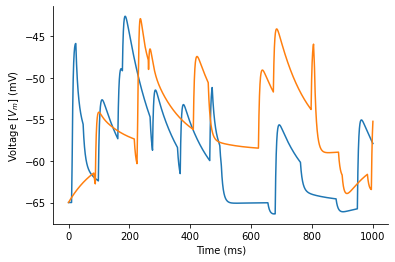

In [11]:
import numpy as np
T = 1000 # duration (ms)
dt = 0.1 # time step (ms)

# create a simulator
sim = Simulator()

# create a neuron with input
nrn = MyFirstNeuron(23, 11, name='my 1st neuron!')
nrn.set_inh_input(np.random.randint(0, T, size=10))
nrn.set_exc_input(np.random.randint(0, T, size=10))

nrn2 = MyFirstNeuron(23, 11, name='my 2nd neuron!')
nrn2.set_inh_input(np.random.randint(0, T, size=10))
nrn2.set_exc_input(np.random.randint(0, T, size=10))
nrn2.set_external_input(0.05)
                     

# adding all neurons we want to update
sim.add_neuron(nrn)
sim.add_neuron(nrn2)

# run a simulation of a neuron
sim.run(T, dt)

# visualise
import matplotlib.pyplot as plt

# create a figure with an axis for plotting
fig, ax = plt.subplots()

# plot voltage over iterations
ax.plot(sim.t_list, nrn.V_t)
ax.plot(sim.t_list, nrn2.V_t)

# make the borders prettier
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# add some axis labels
ax.set_ylabel("Voltage [$V_m$] (mV)")
ax.set_xlabel("Time (ms)")

plt.show()

existing Simulator
creating neuron my 1st neuron!
creating neuron my 1st neuron with external input
running a simulation for 1000 ms using a dt of 0.1 ms.
There will be 10000 iterations for each of 3 neurons


done!


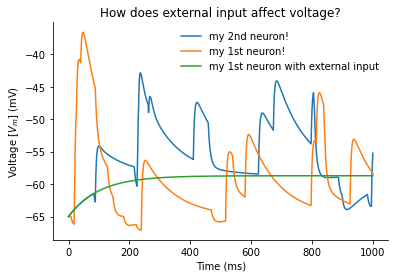

In [13]:
T = 1000 # duration (ms)

dt = 0.1 # time step (ms)

# create a simulator
sim = Simulator()

# create a neuron with input
nrn = MyFirstNeuron(23, 11, 'my 1st neuron!')
exc_input = np.random.randint(0, T, size=10)
inh_input = np.random.randint(0, T, size=10)

nrn.set_inh_input(inh_input)
nrn.set_exc_input(exc_input)

#create ANOTHER neuron with external input
nrn_with_ext_input = MyFirstNeuron(23, 11, 'my 1st neuron with external input')
nrn_with_ext_input.set_external_input(0.05)

# adding all neurons we want to update
sim.add_neuron(nrn)
sim.add_neuron(nrn_with_ext_input)

# run a simulation of a neuron
sim.run(T, dt)

# visualise
import matplotlib.pyplot as plt

# create a figure with an axis for plotting
fig, ax = plt.subplots()

# plot voltage over iterations
names = []
for n in sim.neurons:
    ax.plot(sim.t_list, n.V_t)
    names.append(n.name)

# this is a *list comprehension*
names = [n.name for n in sim.neurons]
ax.legend(names, frameon=False)

# add some axis labels
ax.set_ylabel("Voltage [$V_m$] (mV)")
ax.set_xlabel("Time (ms)")

# don't forget a title
ax.set_title("How does external input affect voltage?")

# make the borders prettier
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

**Task 3**

Instead of the **analytical** solution (can compute any time `t`) for `g_syn`, implement the **numerical** solution (need to know `t-1` to calculate `t`).

$\begin{aligned}
\frac{dg_{syn}}{dt} &= -\frac{g_{syn}}{\tau_{syn}} \\
g_{syn} &= g_{syn} + g_{syn_{\rm{max}}}   (\textrm{when } t = t_{s})
\end{aligned}$

Further questions
1. What are the advantages + disadvantages between the 2 solutions?
1. Derive the numerical solution from the analytical solution (ignore the $\sum$)
1. Integrate the numerical solution to get the analytical solution

## The Leaky Integrate-and-Fire Neuron

Thus far, we have implemented the change in voltage given inputs, but there's no concept of an action potential going on!

The simplest approach is to define a *threshold* $V_{thresh}$ for the neuron that once reached at time $t_i$

1. $V_m$ goes to `0` (or `20`) at $t_{i+1}$
1. After hyperpolarises to $V_{reset}$  at $t_{i+2}$

In [15]:
logging.basicConfig(format='%(asctime)s %(name)-15s %(levelname)-8s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger('MyLogger')

logger.setLevel(logging.INFO)
 
logger.debug("Only show when debugging")
logger.info("replace print statements with this instead")
logger.warning("this displays a warning")
logger.error("there was an error")


02:25:07 MyLogger        INFO     replace print statements with this instead
02:25:07 MyLogger        WARNING  this displays a warning
02:25:07 MyLogger        ERROR    there was an error


In [19]:
class LIFNeuron(MyFirstNeuron):
    """
    Leaky integrate-and-fire neuron that inherits from MyFirstNeuron.
    """
    def __init__(self, *args, 
               name="LIF", # replace default
               V_thresh=-55, V_reset=-68, # new arguments
               **kwargs): # other keyword arguments
        logging.debug(f"other arguments passed = {args}")
        logging.debug(f"other keyword arguments passed = {kwargs}")
        super().__init__(*args, name=name, **kwargs)
        self.V_thresh = V_thresh
        self.V_reset = V_reset

    def step(self, t, dt):
        V_t = self.V_t[-1] # get last value
        if V_t == 0:
            # neuron has spiked at previous time step
            V_t = self.V_reset
        elif V_t >= self.V_thresh:
            # voltage has reached threshold, spike!
            V_t = 0
        else:
            # this is repeated from MyFirstNeuron, 
            # but we could also call super().step(t, dt) with some consideration
            # (the parent step method also appends to V_t list)
            I_leak = (V_t - self.V_rest)/self.R_m
            dV = (-I_leak - self._I_syn(t, V_t) + self.I_e*1e-5/self.A) * dt/self.C_m
            V_t = V_t + dV
        self.V_t.append(V_t)

In [17]:
# visualise
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cbook import flatten

def plot_v(sim, attrs=None, title="", **kwargs):
    # note that list parameters should have defaults as None in the method and 
    #   defined in the body, even if it's empty
    if attrs is None:
        attrs = []

    # create a figure with an axis for plotting
    fig, axs = plt.subplots(nrows=1+len(attrs), squeeze=False, sharex=True,
                          gridspec_kw={'height_ratios':[5]+[1]*len(attrs)})
    ax = axs[0, 0]
  # plot voltage over iterations
    for neuron in sim.neurons:
        ax.plot(sim.t_list, neuron.V_t, **kwargs)
        for i, attr in enumerate(attrs):
            try:
                axs[i+1,0].plot(sim.t_list, getattr(neuron, attr))
            except AttributeError:
                logger.debug(f"attribute {attr} did not exist in {neuron.name}. Continuing...")
                logger.debug(f"""do this next time `val = getattr(neuron, attr, None)`
                              [see `help(getattr)`]""")

    names = [n.name for n in sim.neurons]
    ax.legend(names, loc='upper left', bbox_to_anchor=(1,1), frameon=False)

    # add some axis labels
    ax.set_ylabel("$V_m$ (mV)") # <-- math symbols in-between $ $
    axs[-1, -1].set_xlabel("Time (ms)")

    # don't forget a title
    ax.set_title(title)

    # make the borders prettier
    for ax in flatten(axs):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    return fig, axs

existing Simulator
creating neuron LIF
running a simulation for 1000 ms using a dt of 0.1 ms.
There will be 10000 iterations for each of 1 neurons


done!
there were 6 spikes


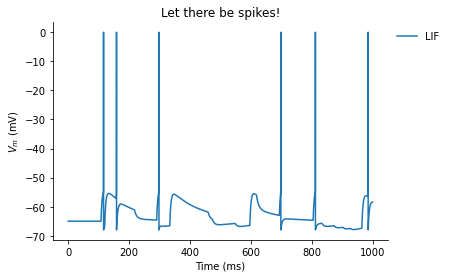

In [20]:
# create a simulator
sim = Simulator()
sim.clean()

T = 1000 # duration (ms)
dt = 0.1 # time step (ms)

# create a neuron with input
lif_nrn = LIFNeuron(23, 11)
lif_nrn.set_inh_input(np.random.randint(0, T, size=10))
lif_nrn.set_exc_input(np.random.randint(0, T, size=10))

sim.add_neuron(lif_nrn)

# run a simulation of a neuron
sim.run(T, dt)

plot_v(sim, title="Let there be spikes!")
print(f"there were {np.sum(np.array(lif_nrn.V_t)>=0)} spikes")

## How does external input current affect the firing rate of a neuron

existing Simulator
creating neuron 0.00
creating neuron 0.05
creating neuron 0.10
creating neuron 0.15
creating neuron 0.20
creating neuron 0.25
creating neuron 0.30
creating neuron 0.35
creating neuron 0.40
creating neuron 0.45
running a simulation for 1000 ms using a dt of 0.1 ms.
There will be 10000 iterations for each of 10 neurons


done!


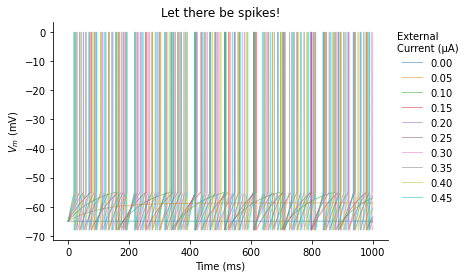

In [23]:
sim = Simulator()
# get rid of previous neurons
sim.clean()

# create neurons each with their own external current value
for current in np.arange(0,0.5,0.05):
    nrn = LIFNeuron(23, 11, name=f"{current:.2f}")
    nrn.set_external_input(current)
    sim.add_neuron(nrn)
sim.run(T, dt)

#@title
fig, ax = plot_v(sim, title="Let there be spikes!", alpha=0.5, lw=1)
ax[0,0].get_legend().set_title("External\nCurrent (μA)")

In [24]:
# convert Voltage for each neuron to an array
v = np.empty(shape=(len(sim.t_list), len(sim.neurons)))
for i,nrn in enumerate(sim.neurons):
    v[:,i] = nrn.V_t
# calculate the instantaneous firing rate
ifr = np.sum(v>=0,axis=0)/(sim.t_list[-1]/1000)

Text(0.5, 1.0, "I-F 'curve'")

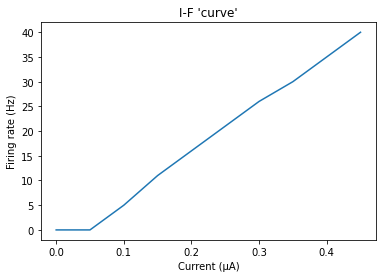

In [26]:
fig, ax = plt.subplots()
ax.plot([float(nrn.name) for nrn in sim.neurons], ifr)
ax.set_xlabel("Current (μA)")
ax.set_ylabel("Firing rate (Hz)")
ax.set_title("I-F 'curve'")

As the amount of input current increases, the firing rate increases

### **TODO**: How does _**excitatory** and **inhibitory** input_ affect the *firing rate* of a neuron?

Similar to above for external current, determine
- how does excitatory drive affect firing rate? 
  - you should produce an input-output (I-O) curve where excitation is on the x-axis and firing rate is on the y-axis

- how does inhibition affect this I-O relationship?

- how does timing of the excitatory + inhibitory inputs affect the relationship? 
  - what if they both have the same input frequency ("Balanced input")
  - what if they have the same frequency, but are offset?
  - what does noise add or take away from this I-O function?

- create a circuit with 2 excitatory neurons and 1 inhibitory neuron. Connect them to each other. \
  *hint when one fires, add a spike time to its connected pair*
  - Increase the number of neurons (try keep a 80:20 percentage of excitatory: inhibitory neurons).
  - Implement Hebbian learning